# Model Testing

This notebook fits various models and gets CV and total AUC scores.



In [5]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, VotingClassifier)
from mlxtend.classifier import StackingCVClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.axes as ax

In [11]:
# read full training data set
df = pd.read_csv('data/train_data_clean_5_grouped.csv')

gender_dummies = pd.get_dummies(df['gender'], 
                             prefix = 'gender', drop_first = True)
df = pd.concat([df, gender_dummies], axis = 1)
df.drop(["gender"], axis = 1, inplace = True)

living_status_dummies = pd.get_dummies(df['living_status'], 
                             prefix = 'living_status', drop_first = True)
df = pd.concat([df, living_status_dummies], axis = 1)
df.drop(["living_status"], axis = 1, inplace = True)

state_dummies = pd.get_dummies(df['state'], 
                               prefix = 'state', drop_first = True)
df = pd.concat([df, state_dummies], axis = 1)
df.drop(["state"], axis = 1, inplace = True)

df = df.sample(frac=1, random_state=5)
df['new_param'] = df.apply(lambda col: col['safty_rating']/(col['past_num_of_claims']+1), axis=1)

df.drop(['claim_number', 'claim_date','fraud_claim_date','fraud_zip_code',
        "fraud_gender", "fraud_marital_status", 'fraud_accident_site', 'fraud_high_education_ind',
         "fraud_address_change_ind", "fraud_living_status", "fraud_witness_present_ind", 
         "fraud_policy_report_filed_ind", "fraud_channel", "fraud_vehicle_category",
         'fraud_vehicle_color', 'fraud_state', 'SP_Index', 'Unem_rate'], axis = 1, inplace = True)
df = df.filter(regex="^(?!state_).*$")
df = df.filter(regex="^(?!vehicle_color_).*$")
df = df.filter(regex="^(?!claim_day_).*$")
df = df.filter(regex="^(?!claim_month_).*$")

X = df.drop(['fraud'], axis=1)
y = df['fraud']

Set up the hyperparameters for the models. I haven't tried tuning them yet, so the performance could be better.

In [4]:
# AdaBoost parameters
ada_params = {
    'n_estimators': 116,
    'learning_rate': 0.1554
}

# Random Forest parameters
rf_params = {
    'n_estimators': 235,
    'max_depth': 84,
    'min_samples_leaf': 34,
    'max_features': 'sqrt'
}

# Logistic Regression parameters
lr_params = {
    'penalty': 'l1'
}

# XGBoost parameters
xgb_params = {
            "max_depth": 3, "learning_rate": 0.06, "n_estimators": 180, "silent": True, "objective": 'binary:logistic',
            "gamma": 0.35, "min_child_weight": 5, "max_delta_step": 0,  "subsample": 0.8, "colsample_bytree": 0.785,
            "colsample_bylevel": 1, "reg_alpha": 0.01, "reg_lambda": 1, "scale_pos_weight": 1, "seed": 1440, "missing": None
}

# LightGBM parameters
lgmb_params = {
    'boosting_type':'gbdt',  'objective':'binary', 'num_boost_round':800,
               'feature_fraction': .321, 'bagging_fraction':0.50, 'min_child_samples':100,  
               'min_child_weigh':35, 'max_depth':3, 'num_leaves':2, 'learing_rate':0.15,
               'reg_alpha':5, 'reg_lambda': 1.1, 'metric':'auc', 'max_bin': 52,
               'colsample_bytree': 0.9, 'subsample': 0.8, 'is_unbalance': 'true'
}

### Compare models

In [22]:
ada = AdaBoostClassifier(**ada_params)
rf = RandomForestClassifier(**rf_params)
lr = LogisticRegression(**lr_params)
xgb = XGBClassifier(**xgb_params)
lgbm = LGBMClassifier(**lgmb_params)
xgb_lgbm = VotingClassifier(estimators=list(zip(['xgb', 'lgbm'], [xgb, lgbm])), 
                          voting='soft', weights=[6, 4])
models = [ada, rf, lr, xgb, lgbm, xgb_lgbm]
long_labels = ['Adaboost', 'Random Forest', 'Logistic Regression', 'XGBoost', 'LightGBM', 'XGBoost_LightGBM']
print('5-fold cross validation:\n')
for clf, label in zip(models, long_labels):
    scores = model_selection.cross_val_score(clf, X.values, y.values, cv = 5, scoring = 'roc_auc')
    print("AUC: %0.9f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))


5-fold cross validation:

AUC: 0.719963411 (+/- 0.0076) [Adaboost]
AUC: 0.711689776 (+/- 0.0088) [Random Forest]
AUC: 0.709100835 (+/- 0.0122) [Logistic Regression]
AUC: 0.725387261 (+/- 0.0093) [XGBoost]
AUC: 0.729196909 (+/- 0.0087) [LightGBM]
AUC: 0.730128054 (+/- 0.0089) [XGBoost_LightGBM]


### Performance Visualization

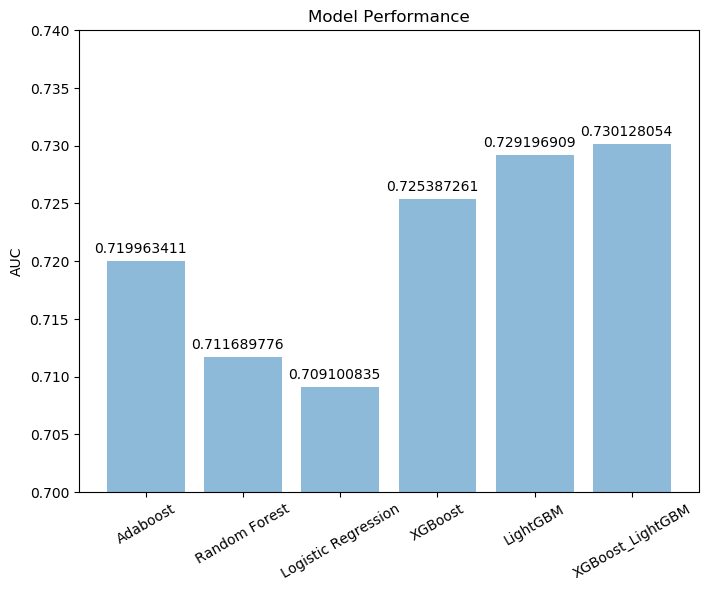

In [6]:
objects = ('Adaboost', 'Random Forest', 'Logistic Regression',
           'XGBoost', 'LightGBM', 'XGBoost_LightGBM')
y_pos = np.arange(len(objects))
performance = (0.719963411, 0.711689776, 0.709100835, 0.725387261,
               0.729196909, 0.730128054)

plt.figure(figsize=(8, 6))
plt.ylim(0.70, 0.74)
rects = plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xticks(rotation=30)
plt.ylabel('AUC')
plt.title('Model Performance')


def autolabel(rects):
    for rect, perf in zip(rects, performance):
        height = rect.get_height()
        plt.text(rect.get_x() - rect.get_width()/6, 1.001*perf, '%s' % float(perf))
autolabel(rects)

plt.show()